https://www.kaggle.com/code/manmohan291/10-tree-classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.datasets

In [2]:
class TreeNode:
    def __init__(self,id, parent=None,vLevel=None,vSplitFeature=None,
                 vOp=None,vSplitValue=None,vSplitSign=None,vPredictedClass=None):
        self.id = id
        self.children=[]
        self.parent=parent
        self.vLevel=vLevel
        self.vSplitFeature=vSplitFeature
        self.vOp=vOp
        self.vSplitValue=vSplitValue
        self.vSplitSign=vSplitSign
        self.vPredictedClass=vPredictedClass
        if(parent!=None):
            parent.children=parent.children+[self]

In [4]:
# Data Generate
def load_dataset(dataset = "noisy_moons"):  
    N = 300
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, 
                        n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    
    
    datasets = {"noisy_circles": noisy_circles,"noisy_moons": noisy_moons,
                "blobs": blobs,"gaussian_quantiles": gaussian_quantiles}
    
    if (dataset=="planar"):
        np.random.seed(1)
        m = 400 # number of examples
        N = int(m/2) # number of points per class
        D = 2 # dimensionality
        X = np.zeros((m,D)) # data matrix where each row is a single example
        Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
        a = 4 # maximum ray of the flower

        for j in range(2):
            ix = range(N*j,N*(j+1))
            t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
            r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        X = X.reshape(Y.shape[0],2 )
        Y = Y.reshape(Y.shape[0],1)
    else:
        X, Y = datasets[dataset]
        X, Y = X.reshape(Y.shape[0],2), Y.reshape(Y.shape[0],1)

    # make blobs binary
    if dataset == "blobs":
        Y = Y%2
        
    return  X, Y

In [5]:
np.random.seed(1) # set a seed so that the results are consistent
#Optioins for dataset "planar","noisy_circles","noisy_moons","blobs","gaussian_quantiles"
X, Y = load_dataset("blobs") 
print(Y.shape,X.shape)
K=2
print("Number of classes=",K)

(300, 1) (300, 2)
Number of classes= 2


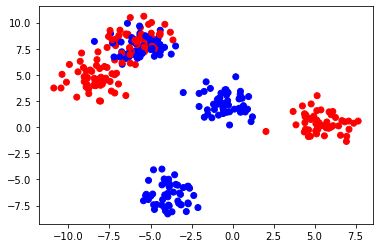

In [6]:
cmap = ListedColormap(['blue', 'red']) 

plt.scatter(X[:, 0].flatten(), X[:, 1].flatten(), c=Y[:, 0].flatten(), cmap=cmap);
plt.show()

In [7]:
# Create Tree
def getGiniScore(X,Y,ri,ci):
    G=0
    S=X[ri,ci]
    Y0=Y[np.where(X[:,ci]<=S)]
    Y1=Y[np.where(X[:,ci]>S)]
    ep=0.00000000001
    
    for i in range(K):
        P=len(Y0[np.where(Y0==i)])/(len(Y0)+ep)
        Q=len(Y1[np.where(Y1==i)])/(len(Y1) +ep)
        G=G+(len(Y0)/len(Y))*P**2 +(len(Y1)/len(Y)) *Q**2

    return G

In [8]:
def getBestSplit(X,Y,ThresholdCount):
    ri=0
    ci=0  
    for i in range(K):
        if(len(Y[np.where(Y==i)])==len(Y)):
            ri=-1
            ci=-1 

    if(X.shape[0]<=ThresholdCount):
        ri=-1
        ci=-1   

    if(ri!=-1 and ci!=-1):
        G=np.zeros((X.shape))
        for ri in range(G.shape[0]):
            for ci in range(G.shape[1]):   
                G[ri,ci]=getGiniScore(X,Y,ri,ci)

        ri=np.unravel_index(np.argmax(G, axis=None), G.shape)[0]
        ci=np.unravel_index(np.argmax(G, axis=None), G.shape)[1]
    
    return ri,ci

In [11]:
def createTree(X, y,Level=1,Node=TreeNode(id="root",vPredictedClass=-1),ThresholdCount=1):
     
    ri,ci=getBestSplit(X,y,ThresholdCount)
  
    if( ri!=-1 and     ci!=-1):
        SplitFeature=ci
        SplitValue=X[ri,ci]

        #PlotTreeSplit(X,SplitFeature,SplitValue,Level)  #Plot While Training
        
        X0=X[np.where(X[:,SplitFeature]<=SplitValue)]
        Y0=y[np.where(X[:,SplitFeature]<=SplitValue)]     
       
        X1=X[np.where(X[:,SplitFeature]>SplitValue)]
        Y1=y[np.where(X[:,SplitFeature]>SplitValue)]
       

        s0 = TreeNode(id="Level_"+str(Level)+"_Left("+"X"+str(SplitFeature)+"<"+str(round(SplitValue,1))+")", 
                      parent=Node,vLevel=Level,vSplitFeature=SplitFeature,vOp="<",vSplitValue=SplitValue,
                      vSplitSign=-1,vPredictedClass=-1)
        s1 = TreeNode(id="Level_"+str(Level)+"_Right("+"X"+str(SplitFeature)+">"+str(round(SplitValue,1))+")", 
                      parent=Node,vLevel=Level,vSplitFeature=SplitFeature,vOp=">",vSplitValue=SplitValue,
                      vSplitSign=1,vPredictedClass=-1)
        s0=createTree(X0,Y0,Level+1,s0,ThresholdCount=ThresholdCount)        
        s1=createTree(X1,Y1,Level+1,s1,ThresholdCount=ThresholdCount)

    else:
        if len(y[np.where(y==0)])<= len(y[np.where(y==1)]):
            Node.vPredictedClass=1
        else:
            Node.vPredictedClass=0
      

    return Node

In [12]:
Threshold=30
print(X.T.shape)
#Training
TrainedTree = createTree(X, Y,ThresholdCount=Threshold)

(2, 300)


In [13]:
# Prediction/Accuracy Evaluation
def predictTree(X,y,Node):
    if(len(Node.children)!=0):
        SplitFeature=Node.children[0].vSplitFeature
        SplitValue=Node.children[0].vSplitValue
        X0=X[np.where(X[:,SplitFeature]<=SplitValue)]
        Y0=y[np.where(X[:,SplitFeature]<=SplitValue)]             
        X1=X[np.where(X[:,SplitFeature]>SplitValue)]
        Y1=y[np.where(X[:,SplitFeature]>SplitValue)]
        newX1,newY1=predictTree(X0,Y0,Node.children[0])
        newX2,newY2=predictTree(X1,Y1,Node.children[1])
        newX= np.concatenate((newX1,newX2),axis=0)
        newY=np.concatenate((newY1,newY2),axis=0)
    else:
        newX=X
        for i in range(len(y)):
            y[i]=Node.vPredictedClass
        newY=y
    return newX,newY

In [14]:
# Accurracy on Training Data
def accurracy(Xy,NewXy):
    Xy=np.sort(Xy,axis=0)
    NewXy=np.sort(NewXy,axis=0)
    Y1=Xy[:,-1]
    Y2=NewXy[:,-1]
    m=np.mean(np.where(Y1==Y2,1,0))    
    return m*100

In [15]:
# Predict using Tree Created
newX,newY=predictTree(X,Y,TrainedTree)
Xy=np.column_stack((X,Y))          #Merge dataset to sort order again 
newXy=np.column_stack((newX,newY)) #Compare requires sorting as Tree shuffled the data in leaf nodes
Accuracy=accurracy(Xy,newXy)
print("Traning  accuracy(",Accuracy,"%).")

Traning  accuracy( 97.66666666666667 %).


In [16]:
# Plotting Hypothesis
def PlotTreeSplit(X,SplitFeature,SplitValue,Level): 
    x_min, x_max = X[:, 0].min() , X[:, 0].max() 
    y_min, y_max = X[:, 1].min() , X[:, 1].max()
    u = np.linspace(x_min, x_max, 2) 
    v = np.linspace(y_min, y_max, 2)      
    for i in range(len(v)): 
        if (SplitFeature==0):        
            u[i] = SplitValue
        else:
            v[i] = SplitValue
    plt.plot(u, v)
    plt.text(u[0],v[0],Level,rotation=90*SplitFeature )
    return


####################################################################
def PlotTree(X,y,Node):
    if(len(Node.children)!=0):
        SplitFeature=Node.children[0].vSplitFeature
        SplitValue=Node.children[0].vSplitValue
        Level=Node.children[0].vLevel
        X0=X[np.where(X[:,SplitFeature]<=SplitValue)]
        Y0=y[np.where(X[:,SplitFeature]<=SplitValue)]     
        X1=X[np.where(X[:,SplitFeature]>SplitValue)]
        Y1=y[np.where(X[:,SplitFeature]>SplitValue)]
        PlotTreeSplit(X,SplitFeature,SplitValue,Level)
        PlotTree(X0,Y0,Node.children[0])
        PlotTree(X1,Y1,Node.children[1])
    else:
        plt.scatter(X[np.where(y==1),0],X[np.where(y==1),1],marker="+")
        plt.scatter(X[np.where(y!=1),0],X[np.where(y!=1),1],marker="o")
    return

####################################################################
def PlotPoints(X,y):
    plt.scatter(X[np.where(y==1),0],X[np.where(y==1),1],marker="+")
    plt.scatter(X[np.where(y!=1),0],X[np.where(y!=1),1],marker="o")
    return

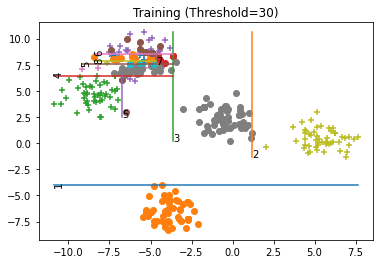

In [17]:
#%matplotlib notebook
plt.subplot(111)  
plt.title("Training (Threshold="+str(Threshold)+")")   
PlotTree(X,Y,TrainedTree)

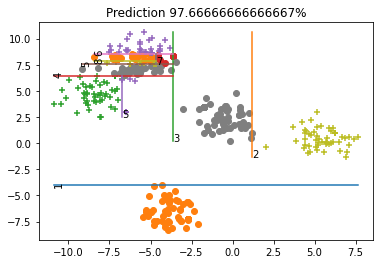

In [18]:
plt.subplot(111) 
plt.title("Prediction "+str(Accuracy)+"%")     
PlotTree(newX,newY,TrainedTree)
plt.show()

In [19]:
# Pruning a tree
def pruneTree(X,y,Node,ThresholdCount):
    if(len(Node.children)!=0):
        SplitFeature=Node.children[0].vSplitFeature
        SplitValue=Node.children[0].vSplitValue
        X0=X[np.where(X[:,SplitFeature]<=SplitValue)]
        Y0=y[np.where(X[:,SplitFeature]<=SplitValue)]             
        X1=X[np.where(X[:,SplitFeature]>SplitValue)]
        Y1=y[np.where(X[:,SplitFeature]>SplitValue)]
        if (X0.shape[0]<ThresholdCount or X1.shape[0]<ThresholdCount):
            Node.children=[]
            PredictedClass=0
            PredictedClassLen=0
            for i in range(int(y.max()+1)):
                if (len(y[np.where(y==i)])>PredictedClassLen):
                    PredictedClass=i
                    PredictedClassLen=len(y[np.where(y==i)])
            Node.vPredictedClass=PredictedClass
        else:            
            pruneTree(X0,Y0,Node.children[0],ThresholdCount)
            pruneTree(X1,Y1,Node.children[1],ThresholdCount)
                
    return Node

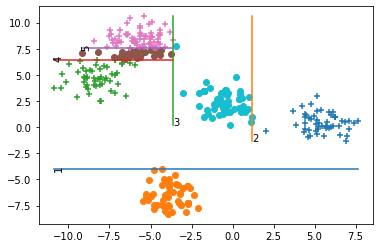

In [20]:
PrunedTree = pruneTree(X, Y, TrainedTree,ThresholdCount=Threshold)
newX,newY=predictTree(X,Y,PrunedTree)
PlotTree(newX,newY,PrunedTree)
plt.show()